 # Project Overview

This capstone project implements a data-driven system to optimize inventory management. It replaces static, rule-based reordering policies with a dynamic, predictive engine that forecasts future demand and calculates the optimal Reorder Point (ROP) and Reorder Quantity (ROQ) for each product.

The goal is to minimize total inventory costs by balancing the reduction of costly stockouts (lost sales) against the minimization of expensive holding costs (storage, capital tied up).

# 1. Import Libraries and Loading Data

In [52]:
# Install Statsmodels
#! pip install statsmodels

In [53]:
# Install Prophet 
#! pip install prophet

In [54]:
#! pip install tensorflow

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import time
import warnings
warnings.filterwarnings("ignore")

In [56]:
data = pd.read_csv('retail_store_inventory.csv')
data.head(10)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer
5,2022-01-01,S001,P0006,Groceries,South,138,128,102,139.82,76.83,10,Sunny,1,79.35,Winter
6,2022-01-01,S001,P0007,Furniture,East,359,97,167,108.92,34.16,10,Rainy,1,36.55,Winter
7,2022-01-01,S001,P0008,Clothing,North,380,312,54,329.73,97.99,5,Cloudy,0,100.09,Spring
8,2022-01-01,S001,P0009,Electronics,West,183,175,135,174.15,20.74,10,Cloudy,0,17.66,Autumn
9,2022-01-01,S001,P0010,Toys,South,108,28,196,24.47,59.99,0,Rainy,1,61.21,Winter


In [57]:
#check the columns and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

- No missing values in my data

In [58]:
data.columns

Index(['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
       'Competitor Pricing', 'Seasonality'],
      dtype='object')

In [59]:
data.shape

(73100, 15)

# 2. EDA

In [60]:
# How many unique stores and products do we have?
num_stores = data['Store ID'].nunique()
num_products = data['Product ID'].nunique()
print(f"Number of unique stores: {num_stores}")
print(f"Number of unique products: {num_products}")

Number of unique stores: 5
Number of unique products: 20


In [61]:
# Convert 'Date' to datetime and create 'SKU_Compound_ID'
data['Date'] = pd.to_datetime(data['Date'])
data['SKU_Compound_ID'] = data['Store ID'] + '_'+ data['Product ID']

In [62]:
data.sort_values(by = ['SKU_Compound_ID', 'Date'], inplace=True)

In [63]:
# Data Quality Check
print(f"Date range: {data['Date'].min()} to {data['Date'].max()}")
print(f"Number of unique SKUs: {data['SKU_Compound_ID'].nunique()}")

Date range: 2022-01-01 00:00:00 to 2024-01-01 00:00:00
Number of unique SKUs: 100


In [67]:
# Total Units sold 
print(f"• Total units sold: {data['Units Sold'].sum():,}")


• Total units sold: 9,975,582


Category and Regional Analysis

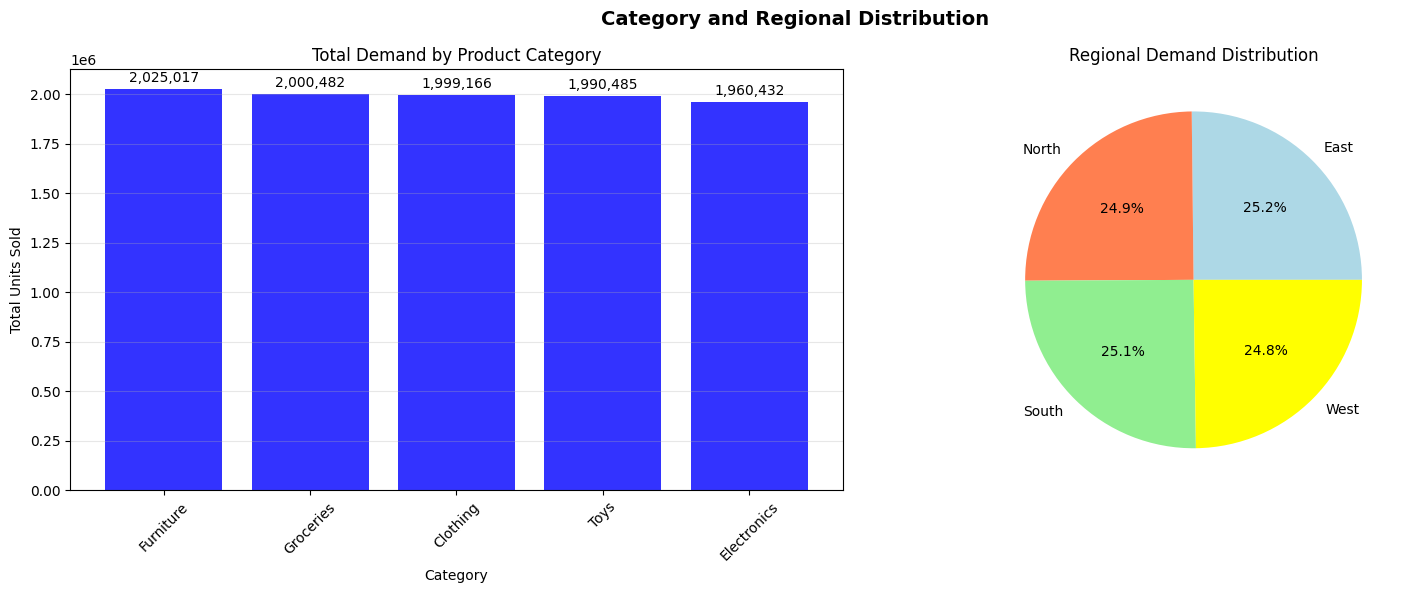

In [ ]:
# Are the categories and regions equally distributed
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Category and Regional Distribution', fontsize=14, fontweight='bold')

# Category-wise demand distribution
category_demand = data.groupby('Category')['Units Sold'].sum().sort_values(ascending=False)
bars = axes[0].bar(category_demand.index, category_demand.values, color='blue', alpha=0.8)
axes[0].set_title('Total Demand by Product Category')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Total Units Sold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, category_demand.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + value*0.01, 
                f'{value:,.0f}', ha='center', va='bottom', fontsize=10)

# Regional demand distribution
regional_demand = data.groupby('Region')['Units Sold'].sum()
colors = ['lightblue', 'coral', 'lightgreen', 'yellow']
wedges, texts, autotexts = axes[1].pie(regional_demand.values, labels=regional_demand.index, 
                                      autopct='%1.1f%%', colors=colors[:len(regional_demand)])
axes[1].set_title('Regional Demand Distribution')

plt.tight_layout()
plt.show()

INSIGHTS

The categories are remarkably balanced - all within about 65,000 units of each other, suggesting a well-diversified product mix!


The regional split is very evenly balanced:
- There is a near-perfect 25% split across all regions indicates excellent geographic distribution of demand.
- There is excellent market penetration and distribution strategy.

The data shows a very mature, well-balanced retail operation with consistent demand across both product categories and geographic regions.

**Price Sensitivity Analysis - Does Price affect Demand?**

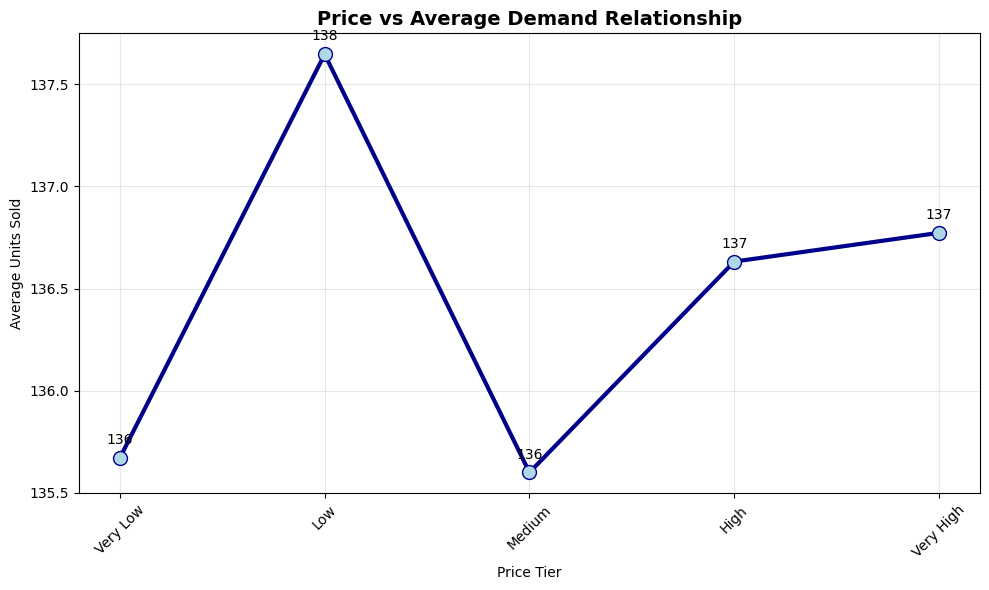

np.float64(0.8116756449759092)

In [70]:
# Create price bins for analysis
price_bins = pd.qcut(data['Price'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
price_demand = data.groupby(price_bins)['Units Sold'].mean()

# Visualize price vs demand relationship
plt.figure(figsize=(10, 6))
plt.plot(price_demand.index, price_demand.values, marker='o', linewidth=3, 
         markersize=10, color='darkblue', markerfacecolor='lightblue')
plt.title('Price vs Average Demand Relationship', fontsize=14, fontweight='bold')
plt.xlabel('Price Tier')
plt.ylabel('Average Units Sold')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Add value annotations
for i, (price_tier, avg_demand) in enumerate(price_demand.items()):
    plt.annotate(f'{avg_demand:.0f}', (i, avg_demand), 
                textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

# Calculate price elasticity
price_elasticity = (price_demand.iloc[-1] - price_demand.iloc[0]) / price_demand.iloc[0] * 100
price_elasticity

INSIGHTS 

1. Low Price Sensitivity: The demand barely changes across different price tiers (only 0.8% variation), indicating customers are not very price-sensitive. 

2. Optimal Pricing Strategy: The "Low" price tier shows the highest demand (138 units), suggesting there's a sweet spot in the lower-medium price range.

3. Business Implications are:
- You have pricing power and can potentially increase margins without significantly losing demand
- Focus on value proposition rather than aggressive price competition


**Discount Impact Analysis - Does Discount affect demand?**

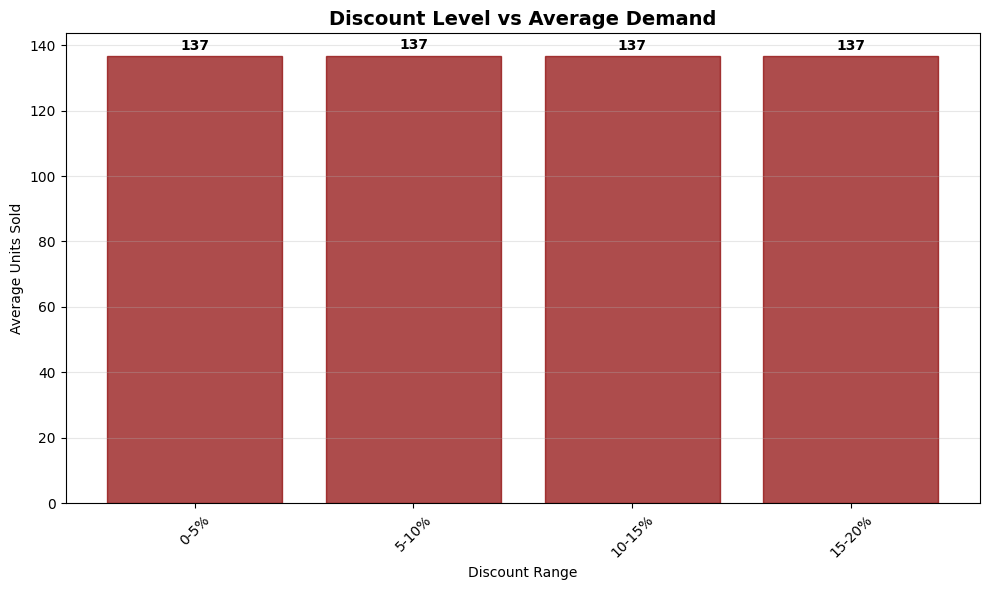

In [71]:
# This analysis will help us see how promotional discounts perform compared to base pricing

# Create discount bins
discount_bins = pd.cut(data['Discount'], bins=[0, 5, 10, 15, 20, 100], 
                      labels=['0-5%', '5-10%', '10-15%', '15-20%', '20%+'])
discount_demand = data.groupby(discount_bins)['Units Sold'].mean()

# Visualize discount impact
plt.figure(figsize=(10, 6))
bars = plt.bar(discount_demand.index, discount_demand.values, 
               color='darkred', alpha=0.7, edgecolor='darkred')
plt.title('Discount Level vs Average Demand', fontsize=14, fontweight='bold')
plt.xlabel('Discount Range')
plt.ylabel('Average Units Sold')
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, value in zip(bars, discount_demand.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{value:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

INSIGHTS

1. There is Zero Discount Impact: Discounts have virtually no effect on demand as they all result in 137 units average demand.
2. Strategic Implications:
- Cost Savings Opportunity: You're giving away margin unnecessarily with deep discounts, withou gaining sales.
- Customer Behavior: Customers aren't price-sensitive to discounts either.

**Holiday/Promotion Impact Analysis**

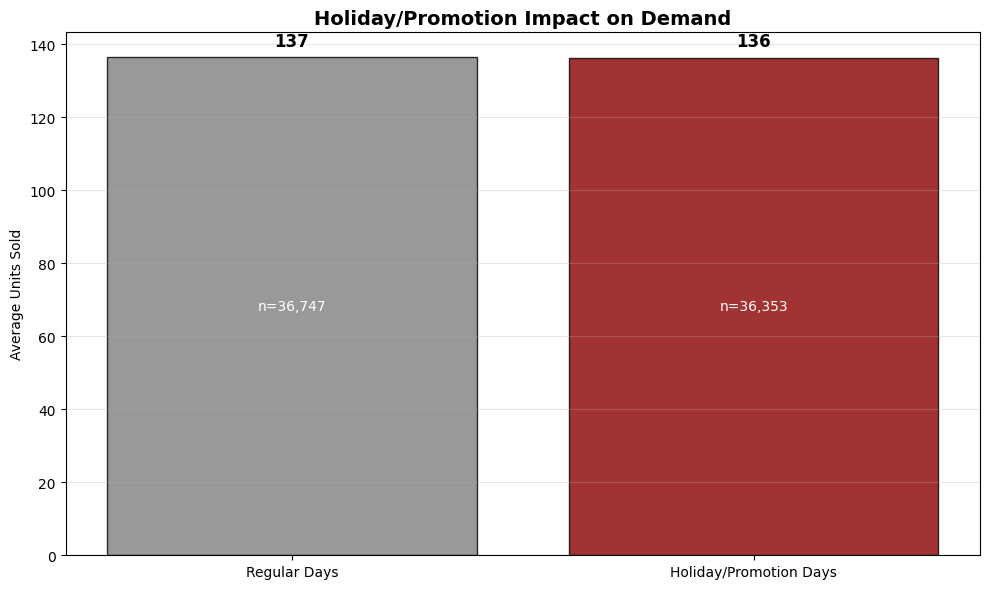

In [72]:
# This helps show us how seasonal factors perform compared to these pricing strategies

# Analyze holiday/promotion impact
holiday_impact = data.groupby('Holiday/Promotion')['Units Sold'].agg(['mean', 'count', 'std'])

# Visualize holiday impact
plt.figure(figsize=(10, 6))
x_labels = ['Regular Days', 'Holiday/Promotion Days']
bars = plt.bar(x_labels, holiday_impact['mean'], 
               color=['gray', 'darkred'], alpha=0.8, edgecolor='black')
plt.title('Holiday/Promotion Impact on Demand', fontsize=14, fontweight='bold')
plt.ylabel('Average Units Sold')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels and count info
for i, (bar, mean_val, count) in enumerate(zip(bars, holiday_impact['mean'], holiday_impact['count'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
            f'{mean_val:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, 
            f'n={count:,}', ha='center', va='center', fontsize=10, color='white')

plt.tight_layout()
plt.show()

INSIGHTS
1. There is over saturation since nearly 50% of days are either holidays or promotions.
2. The low statistical significance means that there is no meaningful difference.
3. All in all; Over-promotion has desensitized customers; holidays don't drive incremental sales

**Weaather Condition Impact Analysis**

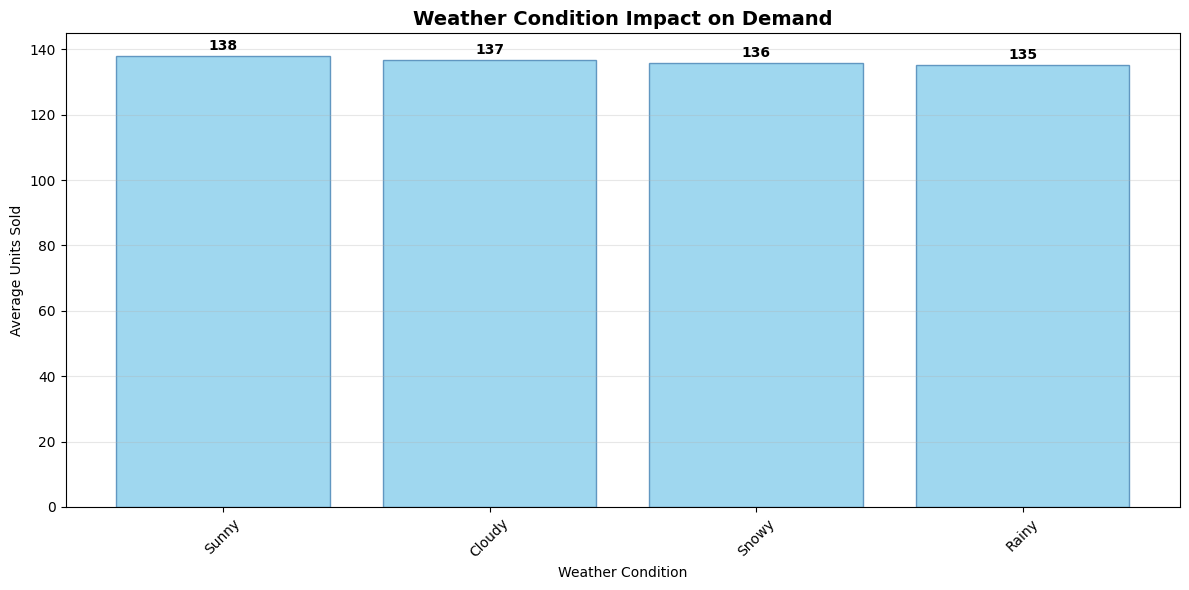

In [73]:
# Analyze weather impact on demand
weather_impact = data.groupby('Weather Condition')['Units Sold'].agg(['mean', 'count', 'std'])
weather_demand = weather_impact['mean'].sort_values(ascending=False)

# Visualize weather impact
plt.figure(figsize=(12, 6))
bars = plt.bar(weather_demand.index, weather_demand.values, 
               color='skyblue', alpha=0.8, edgecolor='steelblue')
plt.title('Weather Condition Impact on Demand', fontsize=14, fontweight='bold')
plt.xlabel('Weather Condition')
plt.ylabel('Average Units Sold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, weather_demand.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{value:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


INSIGHTS 

- Low weather sensitivity.
- Retail is likely indoor/online where weather doesn't affect shopping behavior.

Numeric columns found: ['Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing']


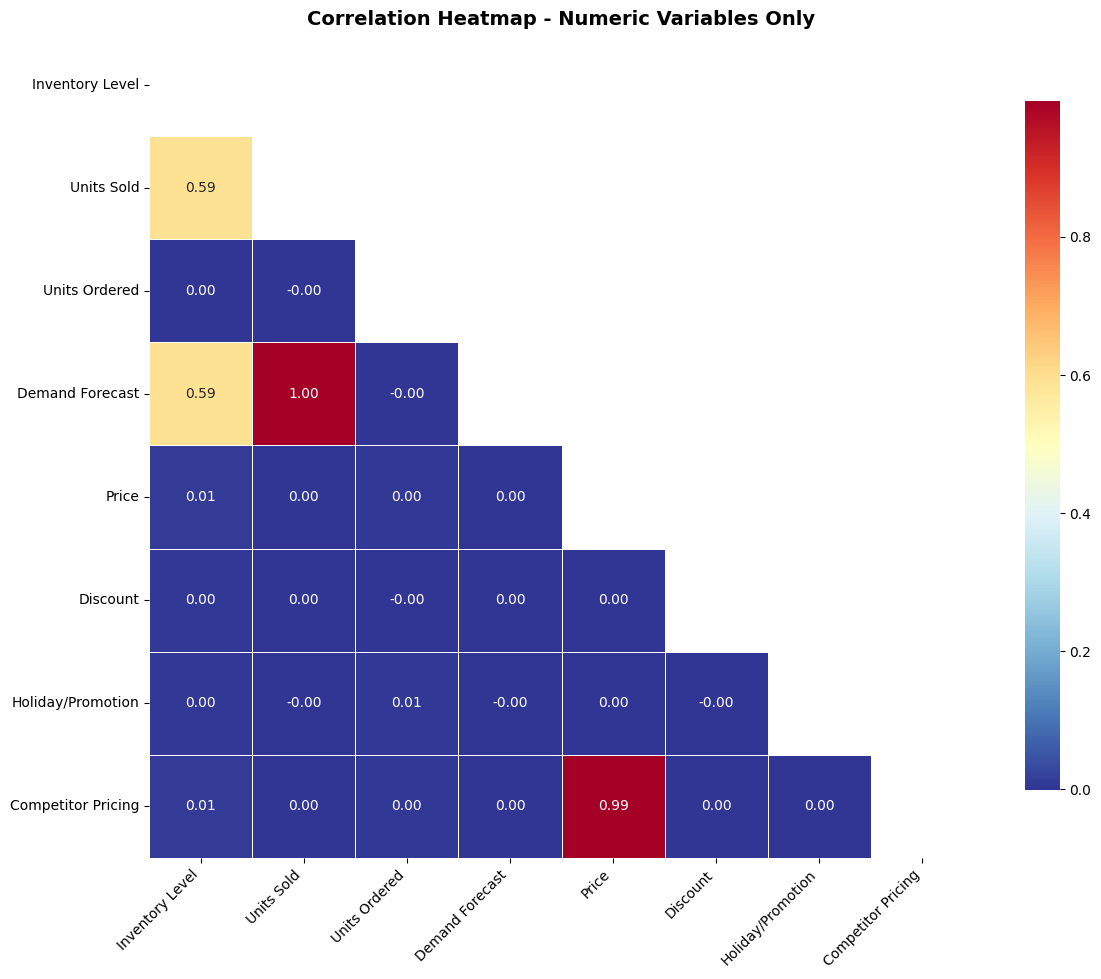

In [ ]:
# Correlation Analysis - Numeric Columns Only
numeric_columns = data.select_dtypes(include=[np.number]).columns
print(f"Numeric columns found: {list(numeric_columns)}")

# Calculate correlations for numeric data only
correlations = data[numeric_columns].corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlations, dtype=bool))  # Show only lower triangle
sns.heatmap(correlations, mask=mask, annot=True, cmap='RdYlBu_r', fmt=".2f", 
            linewidths=0.5, cbar_kws={'shrink': 0.8}, square=True)
plt.title('Correlation Heatmap - Numeric Variables Only', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

INSIGHTS

- Demand is clearly affected by external factors like competitive pricing, customer behaviour.

Logistics and Inventory Management parameters
1. Lead time - How long it takes from placing an order with the supplier until the goods arrive.
2. Holding (carrying) cost - Rep the expense of keeping inventory in storage. This includes warehouse, depreciation, insurance and opportunity cost of capital
3. Ordering Cost - the fixed cost of placing one order, regardless of quantity. This includes administrative work, shipping, handling, and setup.
4. Service Level - is the probability of not running out of stock during the lead time.
5. Z-score (from the normal distribution) helps calculate safety stock. 

      Safety Stock = Z x std demand x square root of Lead time

  So, a Z = 1.645 gives a 95% confidence that demand during lead time will be covered.